# 1 Basic Vectorization

Vectorization refers to processing multiple compute-intensive steps in parallel. This is done by formulating by computation steps in terms of vectors and using efficient math like dot-product to speed up calculation

In [1]:
from time import perf_counter
import numpy as np # version = 1.24.3
import torch # version = 2.0.0 + cu118
from matplotlib import pyplot as plt
from tqdm import tqdm

### Comparing speedup for loop-based vs matmul based dot-product for 1D array
- Two random 1D torch FloatTensors a, b are created each of size 10, 100, 1000, 10000, 100000
- Time required to obtain dot product using loop is calculated as mean of 30 runs (ignoring first 3 runs) to reduce variance
- The same procedure is done for torch.matmul operation -> a @ b.T
- Speedup is represented as multiples: Ratio of ```time_taken_for_loop / time_taken_for_matmul```

Size of a, b: 10| Dot Product| Value: 1.80E+00, Loop time: 3.26E-06s
Size of a, b: 10| Dot Product| Value: 1.80E+00, Matmul time: 1.22E-06s
SpeedUp of matmul compared to loop for size 10: 2.68 x

Size of a, b: 100| Dot Product| Value: 2.19E+01, Loop time: 2.29E-05s
Size of a, b: 100| Dot Product| Value: 2.19E+01, Matmul time: 1.17E-06s
SpeedUp of matmul compared to loop for size 100: 19.66 x

Size of a, b: 1000| Dot Product| Value: 2.57E+02, Loop time: 2.47E-04s
Size of a, b: 1000| Dot Product| Value: 2.57E+02, Matmul time: 1.48E-06s
SpeedUp of matmul compared to loop for size 1000: 166.8 x

Size of a, b: 10000| Dot Product| Value: 2.49E+03, Loop time: 2.51E-03s
Size of a, b: 10000| Dot Product| Value: 2.49E+03, Matmul time: 4.36E-06s
SpeedUp of matmul compared to loop for size 10000: 576.57 x

Size of a, b: 100000| Dot Product| Value: 2.50E+04, Loop time: 2.56E-02s
Size of a, b: 100000| Dot Product| Value: 2.50E+04, Matmul time: 8.69E-05s
SpeedUp of matmul compared to loop for size 10

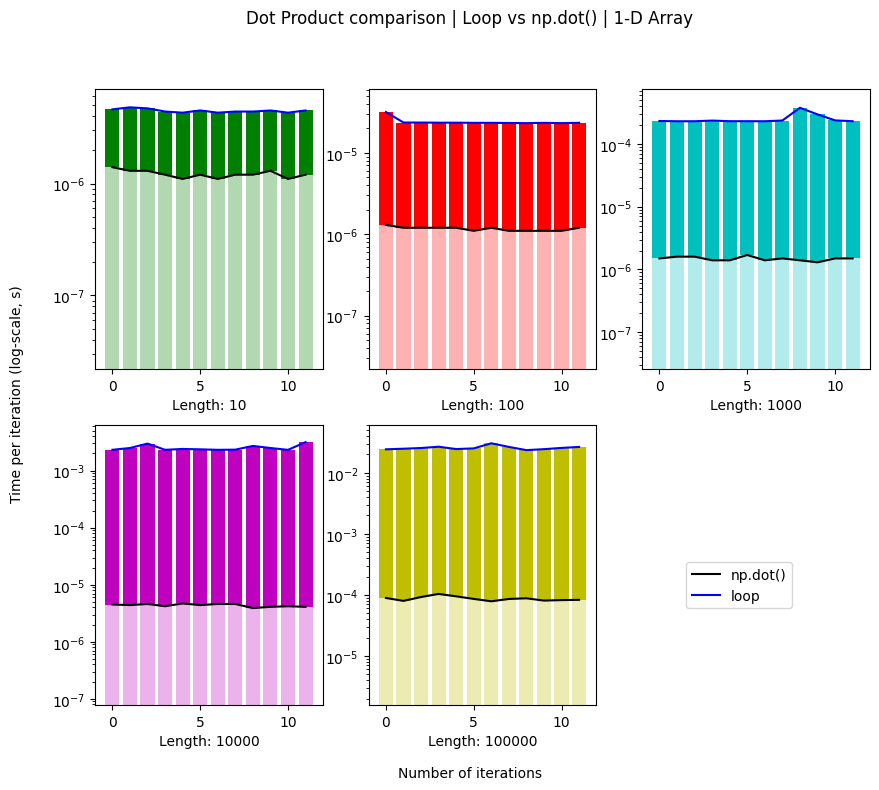

In [2]:
SIZES_OF_ARRAY = [10, 100, 1000, 10000, 100000]
COLORS = ["g", "r", "c", "m", "y", "k"]
NUMBER_ITERS = 15
IGNORE_ITERS = 2

N_ROWS = 2
N_COLUMNS = 3
fig, ax = plt.subplots(N_ROWS, N_COLUMNS, figsize=(10, 8))
fig.suptitle("Dot Product comparison | Loop vs np.dot() | 1-D Array")
ax.flat[-1].set_visible(False) # to remove last plot

for axis, size_of_array, color in zip(fig.axes, SIZES_OF_ARRAY, COLORS):
    bottom = np.zeros(NUMBER_ITERS - IGNORE_ITERS - 1)
    a = np.random.random(size_of_array)
    b = np.random.random(size_of_array)

    avg_loop_time_list = []
    for _ in range(NUMBER_ITERS): # Doing same computation for 20 times to reduce runtime variance
        dot_loop_value = 0.0
        t_loop_start = perf_counter()
        for index in range(a.shape[0]):
            dot_loop_value += a[index] * b[index]
        t_loop_end = perf_counter()
        
        t_loop_total = t_loop_end - t_loop_start
        if _ > IGNORE_ITERS: # Ignoring first 3 loop iterations, to further reduce the noise
            avg_loop_time_list.append(t_loop_total)
    avg_loop_time_list = np.array(avg_loop_time_list)
    avg_loop_time = np.mean(avg_loop_time_list)
    print(f"Size of a, b: {size_of_array}| Dot Product| Value: {dot_loop_value:.2E}, Loop time: {avg_loop_time:.2E}s")

    avg_matmul_time_list = []
    for _ in range(NUMBER_ITERS): # Doing same computation for 20 times to reduce runtime variance
        t_matmul_start = perf_counter()
        dot_np_value = a @ b.T
        t_matmul_end = perf_counter()
        
        t_matmul_total = t_matmul_end - t_matmul_start
        if _ > IGNORE_ITERS: # Ignoring first 3 loop iterations, to further reduce the noise
            avg_matmul_time_list.append(t_matmul_total)
    avg_matmul_time_list = np.array(avg_matmul_time_list)
    avg_matmul_time = np.mean(avg_matmul_time_list)
    print(f"Size of a, b: {size_of_array}| Dot Product| Value: {dot_np_value:.2E}, Matmul time: {avg_matmul_time:.2E}s")

    speedUp = (avg_loop_time / avg_matmul_time)
    print(f"SpeedUp of matmul compared to loop for size {size_of_array}: {round(speedUp, 2)} x\n")

    axis.set_yscale("log")
    axis.set_xlabel(f"Length: {size_of_array}")
    min_value = np.amin(avg_matmul_time_list)
    max_value = np.amax(avg_loop_time_list)
    axis.set_ylim(min_value * 0.2E-1, max_value * 0.2E+1)
    axis.plot(avg_matmul_time_list, color="black")
    axis.bar(range(NUMBER_ITERS - IGNORE_ITERS - 1), avg_matmul_time_list, color=color, alpha=0.3, label="np.dot()")
    bottom += avg_matmul_time_list

    axis.plot(avg_loop_time_list + bottom, color="b")
    axis.bar(range(NUMBER_ITERS - IGNORE_ITERS - 1), avg_loop_time_list, color=color, bottom=bottom, label="loop")

fig.text(0.5, 0.02, "Number of iterations", ha='center')
fig.text(0.04, 0.5, "Time per iteration (log-scale, s)", va='center', rotation='vertical')
fig.legend(["np.dot()", "loop"], loc=(0.78, 0.23))
plt.show()

### Comparing speedup for loop-based vs torch.matmul for matrix multiplication of N-D array
- Two random N-D Torch FloatTensors a, b are created each of size 10, 100, 1000
- Time required to obtain dot product using loop is calculated as mean of 15 runs to reduce variance
- The same procedure is done for torch.matmul operation -> a @ b
- Speedup is represented as multiples: Ratio of ```time_taken_for_loop / time_taken_for_matmul```

Note: This cell took a long time to run for array size 1000 (around 110 mins in my laptop)

Size of a, b: 10| Loop time: 4.83E-04s
Size of a, b: 10| np.matmul time: 1.99E-06s
SpeedUp of matmul for N-D tensor compared to loop for size 10: 242.47 x

Size of a, b: 100| Loop time: 4.38E-01s
Size of a, b: 100| np.matmul time: 1.28E-04s
SpeedUp of matmul for N-D tensor compared to loop for size 100: 3410.89 x

Size of a, b: 1000| Loop time: 5.98E+02s
Size of a, b: 1000| np.matmul time: 1.43E-02s
SpeedUp of matmul for N-D tensor compared to loop for size 1000: 41911.79 x



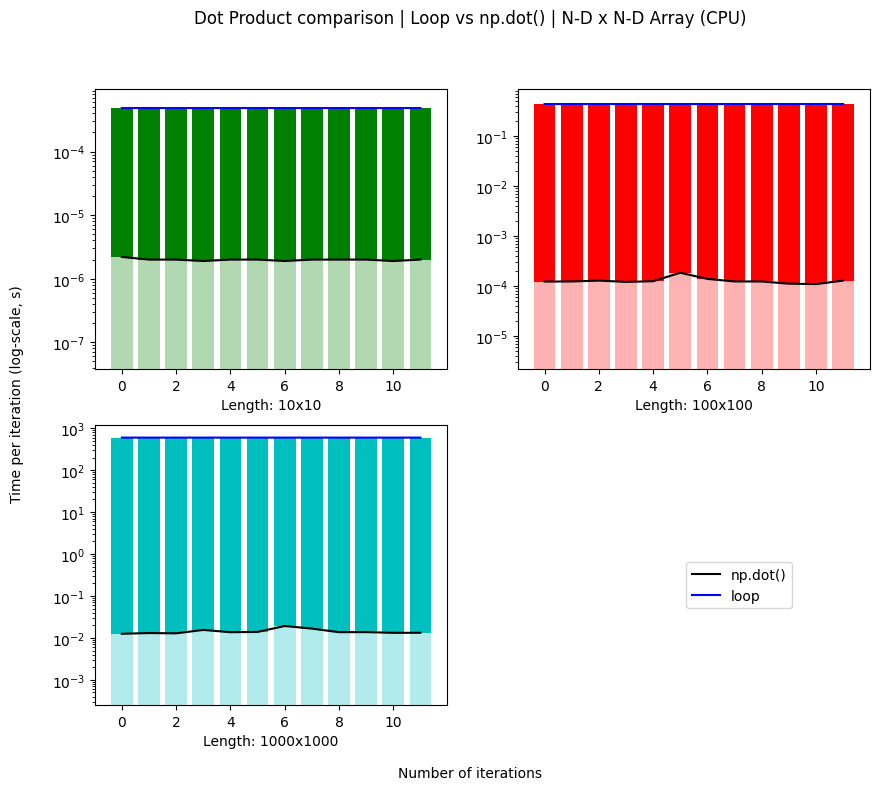

In [2]:
SIZES_OF_ARRAY = [10, 100, 1000] # , 10000]
COLORS = ["g", "r", "c", "m", "y", "k"]
NUMBER_ITERS = 15
IGNORE_ITERS = 2

N_ROWS = 2
N_COLUMNS = 2
fig, ax = plt.subplots(N_ROWS, N_COLUMNS, figsize=(10, 8))
fig.suptitle("Dot Product comparison | Loop vs np.dot() | N-D x N-D Array (CPU)")
ax.flat[-1].set_visible(False) # to remove last plot

for axis, size_of_array, color in zip(fig.axes, SIZES_OF_ARRAY, COLORS):
    bottom = np.zeros(NUMBER_ITERS - IGNORE_ITERS - 1)
    a = np.random.random((size_of_array, size_of_array))
    b = np.random.random((size_of_array, size_of_array))

    avg_loop_time_nd_list = []
    for _ in range(NUMBER_ITERS): # Doing same computation for NUMBER_ITERS times to reduce runtime variance
        result = []
        t_loop_start = perf_counter()
        for i in range(a.shape[0]):
            row = []
            for j in range(b.shape[1]):
                product = 0
                for k in range(a.shape[1]):
                    product += a[i][k] * b[k][j]
                row.append(product)
            result.append(row)
        t_loop_end = perf_counter()
        
        t_loop_total = t_loop_end - t_loop_start
        if _ > IGNORE_ITERS: # Ignoring first 3 loop iterations, to further reduce the noise
            avg_loop_time_nd_list.append(t_loop_total)
    avg_loop_time_nd_list = np.array(avg_loop_time_nd_list)
    avg_loop_time_nd = np.mean(avg_loop_time_nd_list)

    print(f"Size of a, b: {size_of_array}| Loop time: {avg_loop_time_nd:.2E}s")

    avg_matmul_time_nd_list = []
    for _ in range(NUMBER_ITERS): # Doing same computation for 20 times to reduce runtime variance
        t_matmul_start = perf_counter()
        dot_np_value = a @ b
        t_matmul_end = perf_counter()
        
        t_matmul_total = t_matmul_end - t_matmul_start
        if _ > IGNORE_ITERS: # Ignoring first 3 loop iterations, to further reduce the noise
            avg_matmul_time_nd_list.append(t_matmul_total)
    avg_matmul_time_nd_list = np.array(avg_matmul_time_nd_list)
    avg_matmul_time_nd = np.mean(avg_matmul_time_nd_list)
    
    print(f"Size of a, b: {size_of_array}| np.matmul time: {avg_matmul_time_nd:.2E}s")

    speedUp = (avg_loop_time_nd / avg_matmul_time_nd)
    print(f"SpeedUp of matmul for N-D tensor compared to loop for size {size_of_array}: {round(speedUp, 2)} x\n")

    axis.set_yscale("log")
    axis.set_xlabel(f"Length: {size_of_array}x{size_of_array}")
    min_value = np.amin(avg_matmul_time_nd_list)
    max_value = np.amax(avg_loop_time_nd)
    axis.set_ylim(min_value * 0.2E-1, max_value * 0.2E+1)
    axis.plot(avg_matmul_time_nd_list, color="black")
    axis.bar(range(NUMBER_ITERS - IGNORE_ITERS - 1), avg_matmul_time_nd_list, color=color, alpha=0.3, label="np.dot()")
    bottom += avg_matmul_time_nd_list

    axis.plot(avg_loop_time_nd + bottom, color="b")
    axis.bar(range(NUMBER_ITERS - IGNORE_ITERS - 1), avg_loop_time_nd, color=color, bottom=bottom, label="loop")
    
fig.text(0.5, 0.02, "Number of iterations", ha='center')
fig.text(0.04, 0.5, "Time per iteration (log-scale, s)", va='center', rotation='vertical')
fig.legend(["np.dot()", "loop"], loc=(0.78, 0.23))
plt.show()

### torch.matmul for matrix multiplication of N-D array in GPUs w.r.t Mixed Precision (Autocast)
- Two random N-D Torch FloatTensors a, b are created each of size 10, 100, 1000, 10000
- Time required to obtain dot product using loop is calculated as mean of 20 runs to reduce variance
- The same procedure is done for torch.matmul operation -> a @ b
- Speedup is represented as multiples: Ratio of ```time_taken_for_loop / time_taken_for_matmul```

Size of a, b: 10| torch.matmul (GPU) time: 6.19E-05s
Size of a, b: 10| torch.matmul (GPU + autocast) time: 4.29E-05s
SpeedUp of matmul for AMP in GPU vs GPU for size 10: 1.44 x

Size of a, b: 100| torch.matmul (GPU) time: 3.73E-05s
Size of a, b: 100| torch.matmul (GPU + autocast) time: 5.01E-05s
SpeedUp of matmul for AMP in GPU vs GPU for size 100: 0.75 x

Size of a, b: 1000| torch.matmul (GPU) time: 4.24E-04s
Size of a, b: 1000| torch.matmul (GPU + autocast) time: 2.63E-04s
SpeedUp of matmul for AMP in GPU vs GPU for size 1000: 1.61 x

Size of a, b: 10000| torch.matmul (GPU) time: 3.47E-01s
Size of a, b: 10000| torch.matmul (GPU + autocast) time: 1.00E-01s
SpeedUp of matmul for AMP in GPU vs GPU for size 10000: 3.46 x



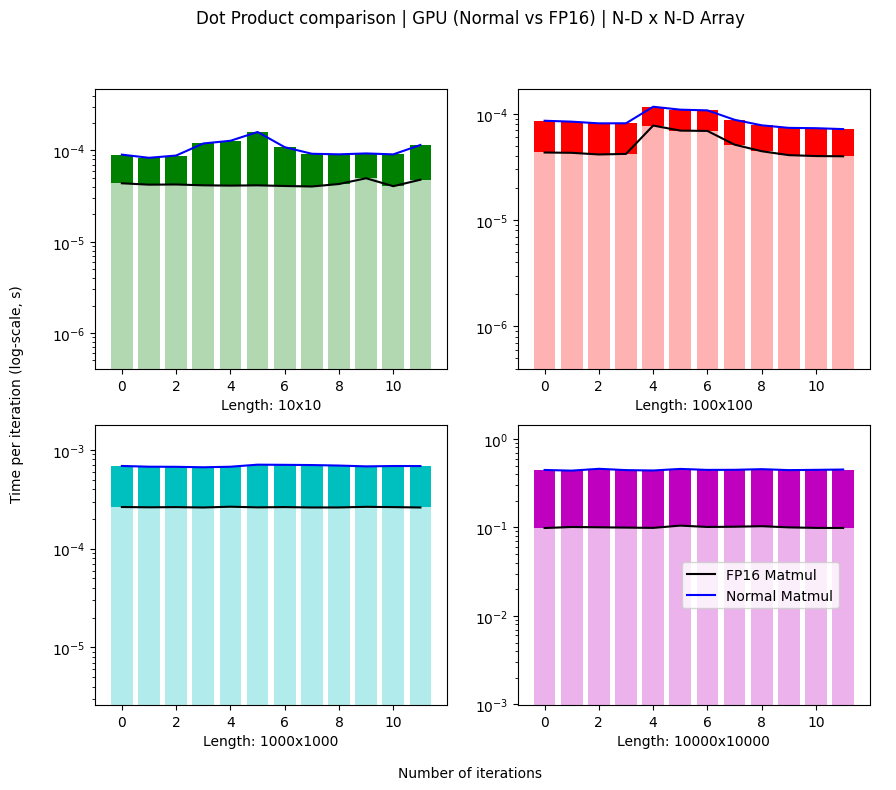

In [3]:
SIZES_OF_ARRAY = [10, 100, 1000, 10000]
COLORS = ["g", "r", "c", "m", "y", "k"]
NUMBER_ITERS = 15
IGNORE_ITERS = 2

N_ROWS = 2
N_COLUMNS = 2
fig, ax = plt.subplots(N_ROWS, N_COLUMNS, figsize=(10, 8))
fig.suptitle("Dot Product comparison | GPU (Normal vs FP16) | N-D x N-D Array")

gpu_device = torch.device("cuda")

for axis, size_of_array, color in zip(fig.axes, SIZES_OF_ARRAY, COLORS):
    bottom = np.zeros(NUMBER_ITERS - IGNORE_ITERS - 1)
    a = torch.rand((size_of_array, size_of_array)).to(gpu_device)
    b = torch.rand((size_of_array, size_of_array)).to(gpu_device)
    torch.cuda.synchronize()     # Synchronizing to finish Async GPU operations

    avg_gpu_matmul_time_list = []
    for _ in range(NUMBER_ITERS): # Doing same computation for 20 times to reduce runtime variance
        t_matmul_start = perf_counter()
        dot_value = a @ b # dot_np_value is float32
        torch.cuda.synchronize() # Synchronizing to finish Async GPU operations
        t_matmul_end = perf_counter()
        
        t_matmul_total = t_matmul_end - t_matmul_start
        if _ > IGNORE_ITERS: # Ignoring first 3 loop iterations, to further reduce the noise
            avg_gpu_matmul_time_list.append(t_matmul_total)
    avg_gpu_matmul_time_list = np.array(avg_gpu_matmul_time_list)
    avg_gpu_matmul_time = np.mean(avg_gpu_matmul_time_list)
    print(f"Size of a, b: {size_of_array}| torch.matmul (GPU) time: {avg_gpu_matmul_time:.2E}s")

    a = torch.rand((size_of_array, size_of_array)).to(device=gpu_device, dtype=torch.float16)
    b = torch.rand((size_of_array, size_of_array)).to(device=gpu_device, dtype=torch.float16)
    torch.cuda.synchronize()     # Synchronizing to finish Async GPU operations

    avg_gpu_autocast_matmul_time_list = []
    for _ in range(NUMBER_ITERS): # Doing same computation for 20 times to reduce runtime variance
        with torch.autocast("cuda"):
            t_matmul_start = perf_counter()
            dot_amp_value = a @ b # Due to autocast, dot_np_value type is float16, input dtypes are float32
            torch.cuda.synchronize() # Synchronizing to finish Async GPU operations
            t_matmul_end = perf_counter()
        
        t_matmul_total = t_matmul_end - t_matmul_start
        if _ > IGNORE_ITERS: # Ignoring first 3 loop iterations, to further reduce the noise
            avg_gpu_autocast_matmul_time_list.append(t_matmul_total)
    avg_gpu_autocast_matmul_time_list = np.array(avg_gpu_autocast_matmul_time_list)
    avg_gpu_autocast_matmul_time = np.mean(avg_gpu_autocast_matmul_time_list)
    print(f"Size of a, b: {size_of_array}| torch.matmul (GPU + autocast) time: {avg_gpu_autocast_matmul_time:.2E}s")

    speedUp = (avg_gpu_matmul_time / avg_gpu_autocast_matmul_time)
    print(f"SpeedUp of matmul for AMP in GPU vs GPU for size {size_of_array}: {round(speedUp, 2)} x\n")

    axis.set_yscale("log")
    axis.set_xlabel(f"Length: {size_of_array}x{size_of_array}")
    min_value = np.amin(avg_gpu_autocast_matmul_time_list)
    max_value = np.amax(avg_gpu_matmul_time_list)
    axis.set_ylim(min_value * 0.1E-1, max_value * 0.4E+1)
    axis.plot(avg_gpu_autocast_matmul_time_list, color="black")
    axis.bar(range(NUMBER_ITERS - IGNORE_ITERS - 1), avg_gpu_autocast_matmul_time_list, color=color, alpha=0.3, label="FP16 Matmul")
    bottom += avg_gpu_autocast_matmul_time_list

    axis.plot(avg_gpu_matmul_time_list + bottom, color="b")
    axis.bar(range(NUMBER_ITERS - IGNORE_ITERS - 1), avg_gpu_matmul_time_list, color=color, bottom=bottom, label="Normal Matmul")
    
fig.text(0.5, 0.02, "Number of iterations", ha='center')
fig.text(0.04, 0.5, "Time per iteration (log-scale, s)", va='center', rotation='vertical')
fig.legend(["FP16 Matmul", "Normal Matmul"], loc=(0.76, 0.23))
plt.show()